# Understanding the CIFAR-10 Dataset

CIFAR-10 consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The classes include:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

The dataset is divided into 50,000 training images and 10,000 testing images. Each image is labeled with one of the ten classes. Let's explore the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


## Importing the necessary libraries


In [2]:
# Python package to open .7z archives
!pip install py7zr;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 25.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import py7zr
import cv2
from sklearn.model_selection import train_test_split

In [4]:
# Extract the 7z file
archive = py7zr.SevenZipFile('/kaggle/input/cifar-10/train.7z', mode='r')
archive.extractall()  # Extract all contents
archive.close()

In [5]:
# Load the list of image filenames from the extracted folder
filenames = os.listdir('/kaggle/working/train')
print(filenames[0:5])  # Print first 5 image filenames

['40078.png', '31960.png', '1395.png', '22921.png', '38949.png']


In [6]:
# Load the labels CSV file
labels_df = pd.read_csv('/kaggle/input/cifar-10/trainLabels.csv')
labels_df.head()  # Check the first few rows

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


# EDA (Exploratory Data Analysis)

In [7]:
# Checking the distribution of labels (class balance)
labels_df['label'].value_counts()  # Class distribution

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

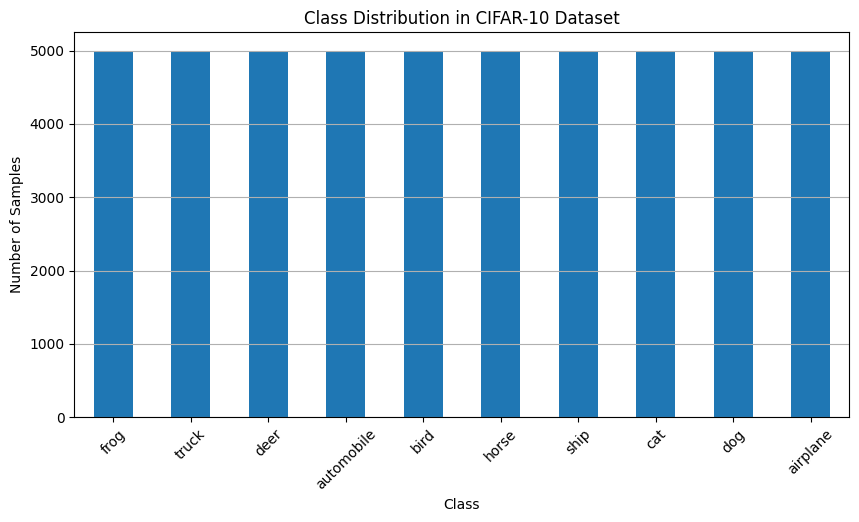

In [8]:
# EDA: Class Distribution
plt.figure(figsize=(10, 5))
labels_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [9]:
# Convert labels to numeric values for model training
labels_dictionary = {
    'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
    'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
}
labels = [labels_dictionary[i] for i in labels_df['label']]

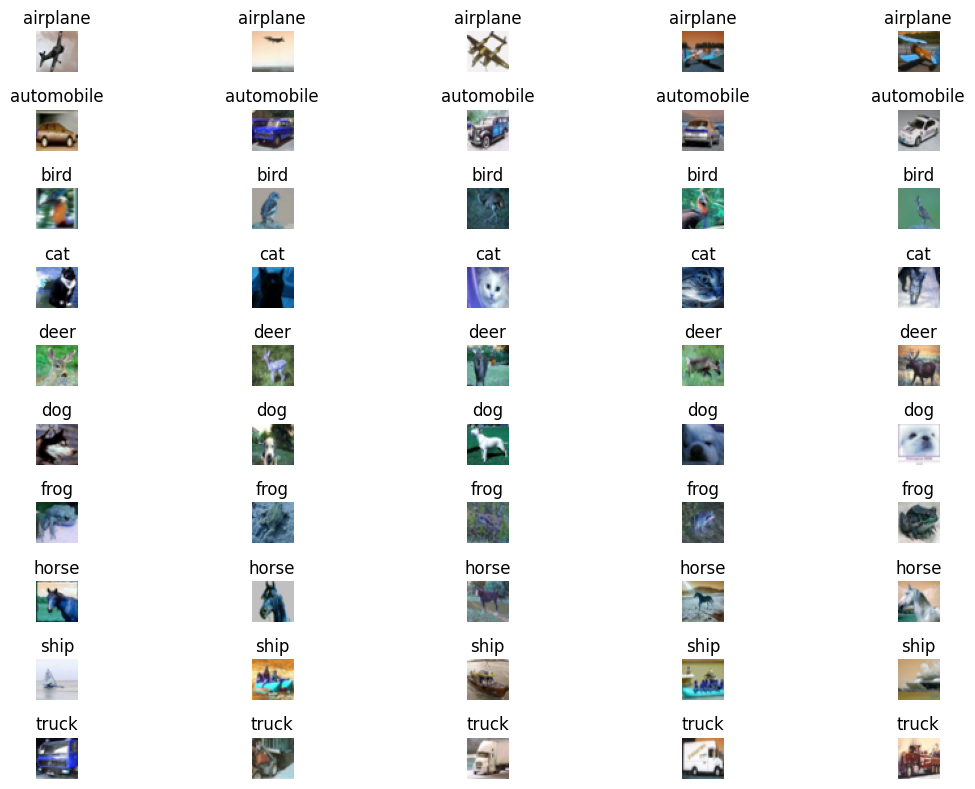

In [10]:
# Some Sample images from each class

plt.figure(figsize=(12, 8))
for i, class_name in enumerate(labels_dictionary.keys()):
    class_images = labels_df[labels_df['label'] == class_name]['id'].sample(5)
    for j, img_id in enumerate(class_images):
        plt.subplot(len(labels_dictionary), 5, i * 5 + j + 1)
        img = cv2.imread(f'train/{img_id}.png')
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
plt.tight_layout()
plt.show()

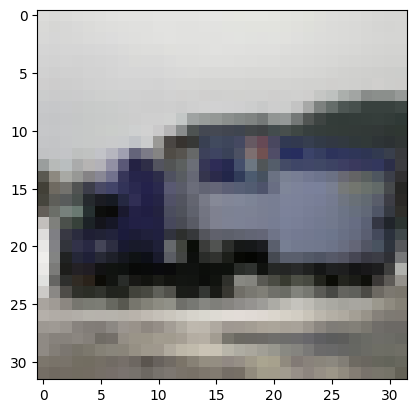

In [11]:
# Visualizing a few images using OpenCV and Matplotlib
img = cv2.imread('train/7761.png')  
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.show()

In [12]:
# Loading images into a NumPy array using OpenCV
train_data_folder = '/kaggle/working/train'
data = []  # List to store image data
for id in labels_df['id']:
    file_path = os.path.join(train_data_folder, f'{id}.png')
    if os.path.isfile(file_path):
        image = cv2.imread(file_path)  
        data.append(image)
    else:
        print(f"File not found: {file_path}")

In [13]:
data = np.array(data)  

In [14]:
# Ensure the images are loaded and verify shape
print(f"Loaded {len(data)} images with shape: {data.shape}")

Loaded 50000 images with shape: (50000, 32, 32, 3)


In [15]:
# Prepare the data for training
X = np.array(data)  # Features (image data)
Y = np.array(labels)  # Labels (numeric)

In [16]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Normalize the image data (scaling pixel values to [0, 1] range)
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [17]:
# Define a Sequential model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),  
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dense(10, activation='softmax')  
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=10)

Epoch 1/10


I0000 00:00:1728559542.348433      82 service.cc:145] XLA service 0x7c5d94002320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728559542.348486      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 105/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1590 - loss: 2.3386

I0000 00:00:1728559543.226177      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2374 - loss: 2.0729 - val_accuracy: 0.3282 - val_loss: 1.8540
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3200 - loss: 1.8743 - val_accuracy: 0.3338 - val_loss: 1.8197
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3273 - loss: 1.8460 - val_accuracy: 0.3310 - val_loss: 1.8243
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3397 - loss: 1.8259 - val_accuracy: 0.3383 - val_loss: 1.8218
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3437 - loss: 1.8179 - val_accuracy: 0.3470 - val_loss: 1.8042
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3464 - loss: 1.8103 - val_accuracy: 0.3517 - val_loss: 1.7822
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3457 - loss: 1.8066 - val_accuracy: 0.3548 - val_loss: 1.7794
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3526 - loss: 1.7922 - val_accurac

In [20]:
# ResNet50 Model (CNN with transfer learning)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

In [21]:
# Load pre-trained ResNet50 model without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# resnet_base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# Build a CNN model using ResNet50 as the base
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 3)))  # Input layer
model.add(layers.UpSampling2D((2, 2)))  # Up-sample to 64x64
model.add(layers.UpSampling2D((2, 2)))  # Up-sample to 128x128
model.add(layers.UpSampling2D((2, 2)))  # Up-sample to 256x256
model.add(resnet_base)  # Add the ResNet50 base
model.add(layers.Flatten())  # Flatten the output
model.add(layers.BatchNormalization())  # Normalize the activations
model.add(layers.Dense(128, activation='relu'))  # Dense layer with 128 units
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))  # Dense layer with 64 units
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))  # Output layer (10 classes)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [23]:
# Compile the model
optimizer = optimizers.RMSprop(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,899,018 (156.02 MB)

 Trainable params: 40,583,370 (154.81 MB)

 Non-trainable params: 315,648 (1.20 MB)

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1865168528223704
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1279281277708741144
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [27]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/kaggle/working/model_checkpoint1.weights.h5', save_best_only=False, save_weights_only=True, verbose=1)

In [28]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [29]:
# model.load_weights('model_checkpoint.weights.h5')

In [30]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=11, batch_size=128, callbacks=[checkpoint, early_stopping])


Epoch 1/11


2024-10-10 11:26:46.482009: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,1024,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,2048,8,8]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-10 11:26:47.972179: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.490371217s
Trying algorithm eng0{} for conv (f32[128,1024,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,2048,8,8]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.3404 - loss: 2.0031
Epoch 1: saving model to /kaggle/working/model_checkpoint1.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 271s 713ms/step - accuracy: 0.3409 - loss: 2.0016 - val_accuracy: 0.0922 - val_loss: 3.0216
Epoch 2/11
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7147 - loss: 0.9540
Epoch 2: saving model to /kaggle/working/model_checkpoint1.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 170s 603ms/step - accuracy: 0.7148 - loss: 0.9538 - val_accuracy: 0.1355 - val_loss: 2.6394
Epoch 3/11
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8331 - loss: 0.6769
Epoch 3: saving model to /kaggle/working/model_checkpoint1.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 170s 603ms/step - accuracy: 0.8332 - loss: 0.6768 - val_accuracy: 0.5525 - val_loss: 1.3822
Epoch 4/11
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8953 - loss: 0.5138
Epoch 4: saving model to /kaggle/working/model_checkpoint1.weights.h5
282/282 ━━━━━━━━

In [31]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9298 - loss: 0.2584
Test Accuracy = 0.9320999979972839


### Freezing the hidden layers

In [32]:
for layer in model.layers[:-1]:  # Excluding the (output layer)
    layer.trainable = False

# Checking which layers are trainable
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

Layer 0: up_sampling2d - Trainable: False
Layer 1: up_sampling2d_1 - Trainable: False
Layer 2: up_sampling2d_2 - Trainable: False
Layer 3: resnet50 - Trainable: False
Layer 4: flatten_1 - Trainable: False
Layer 5: batch_normalization - Trainable: False
Layer 6: dense_2 - Trainable: False
Layer 7: dropout - Trainable: False
Layer 8: batch_normalization_1 - Trainable: False
Layer 9: dense_3 - Trainable: False
Layer 10: dropout_1 - Trainable: False
Layer 11: batch_normalization_2 - Trainable: False
Layer 12: dense_4 - Trainable: True


In [33]:
# Save the trained model
model.save('CIFAR_piyush2.h5')

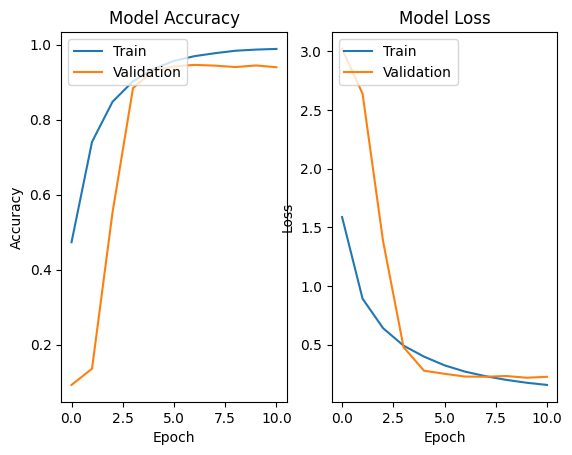

In [34]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
